In [1]:
1+1

2

## Research on Perplexity Differences Between AI and Human-Written Texts

In this study, we will analyze the differences in perplexity between texts written by AI and humans. We will use a previously collected corpus where both human and AI participants were asked to write essays on the topic: "Does the electoral college work?".

### Parameters:
- Analyzing wikipedia article on Pride and Prejudice v.s. ai (gpt4.o) generated text. 
- Only ~512 tokens from each essay will be used for analysis.
- The language model used for perplexity calculation will be the distilled version of GPT-2, which typically yields a perplexity score of 30 to 40 for English texts.

In [2]:
import importlib
import utils.perplexity
importlib.reload(utils.perplexity)
from utils.perplexity import *

the output of the model contains logit of prediction of the next words. 
we need to translate it from logits to probability and perplexity. I have kept some other statistics as well. 

In [21]:
sample_text = "The quick brown fox jumps over the lazy dog and went on to beat the bejesus out of Cthulhu."
calculate_perplexity(sample_text)

168.32095647272962

In [22]:
results = get_sequential_predictions_stats(sample_text)
statsdf = results_to_df(results)
statsdf['perplexity'] = calculate_cumulative_perplexity(statsdf['actual_next_token_prob'])
statsdf.tail(5)

,i,current_token,actual_next_token,logit_mean,logit_std,prob_mean,prob_std,log_prob_mean,log_prob_std,actual_next_token_logit,actual_next_token_prob,actual_next_token_log_prob_z_score,actual_next_token_prob_z_score,actual_next_token_logit_z_score,actual_next_token_rank,perplexity
17,17,es,us,-81.116623,2.667905,0.00002,0.003771,-18.286821,2.038956,-62.474201,8.444026e-01,8.885769,223.907011,6.987664,1,176.909561
18,18,us,Ġout,-80.779572,2.895916,0.00002,0.001007,-16.185043,2.639831,-66.913719,8.393186e-02,5.192489,83.313650,4.788071,3,153.491394
19,19,Ġout,Ġof,-46.146397,2.358169,0.00002,0.003848,-17.933634,1.986163,-28.047075,8.617926e-01,8.954396,223.960444,7.675160,1,120.229127
20,20,Ġof,ĠCthulhu,-64.772491,3.074403,0.00002,0.002755,-16.903265,2.627918,-62.505692,3.223315e-07,0.745334,-0.007106,0.737314,12468,194.996130
21,21,ĠCthulhu,.,-65.501678,2.425822,0.00002,0.001050,-14.639668,2.364465,-52.864002,1.310146e-01,5.331955,124.724949,5.209648,2,168.288999


In [ ]:
import matplotlib.pyplot as plt

stat_cols =[
           'logit_mean', 'logit_std', 
           'prob_mean', 'prob_std', 'log_prob_mean', 'log_prob_std', 
           'actual_next_token_logit', 'actual_next_token_prob', 
           'actual_next_token_prob_z_score', 'actual_next_token_logit_z_score', 'actual_next_token_rank', 'perplexity']

def plot_stats(statsdf, stat_cols, labelwords = False):
    fig, axes = plt.subplots(nrows=len(stat_cols) // 2, ncols=2, figsize=(15, 20))

    for ax, column in zip(axes.flatten(), stat_cols):
        ax.plot(statsdf['i'], statsdf[column])
        ax.set_title(f'{column} vs token count', fontsize=20)
        ax.set_xlabel('Token Count', fontsize=15)
        ax.set_ylabel(column, fontsize=15)
        if labelwords: 
            ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
            ax.set_xticks(statsdf['i'])
            ax.set_xticklabels(statsdf['actual_next_token'], rotation=90, fontsize=12)
        if column == 'perplexity' :
            ax.set_yscale('log')
            ax.set_ylim(10, 1000)
        elif column == 'actual_next_token_rank':
            ax.set_yscale('log')
            ax.set_ylim(1, 10000)

    plt.tight_layout()
    plt.show()


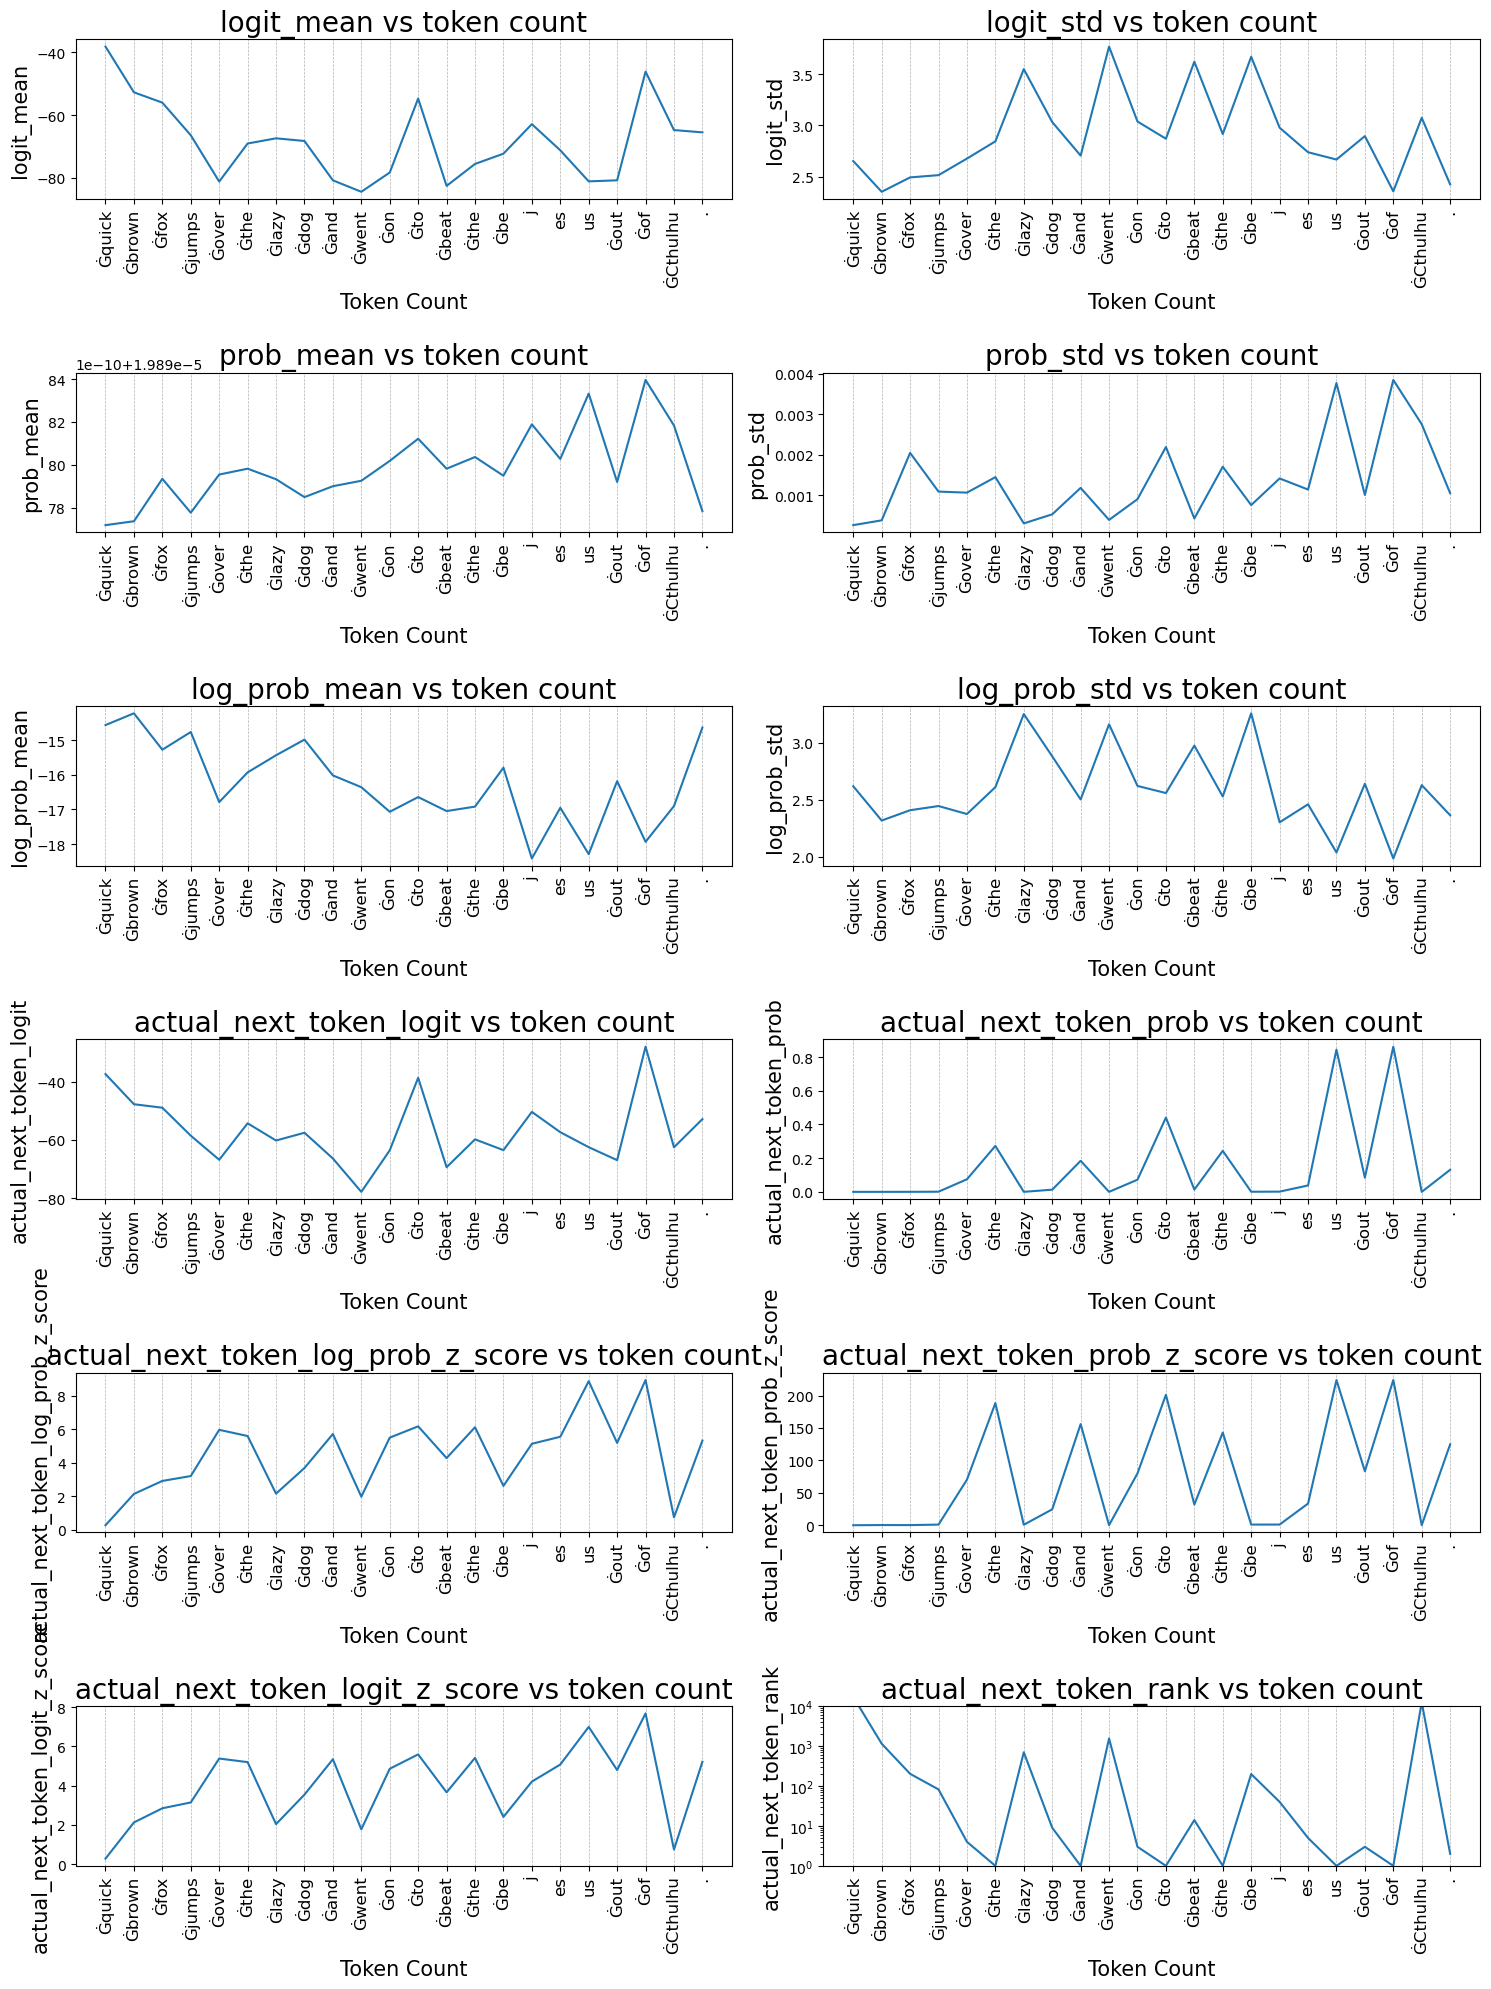

In [24]:
plot_stats(statsdf, stat_cols, labelwords=True)

now try something a bit longer, the introduction to the Price and Prejudice article


In [25]:

with open('utils/pride.txt', 'r') as file:
    sample_text = file.read()
print(len(sample_text.split()))

1120


In [26]:
results = get_sequential_predictions_stats(sample_text, max_tokens= 512)
statsdf = results_to_df(results)
statsdf['perplexity'] = calculate_cumulative_perplexity(statsdf['actual_next_token_prob'])

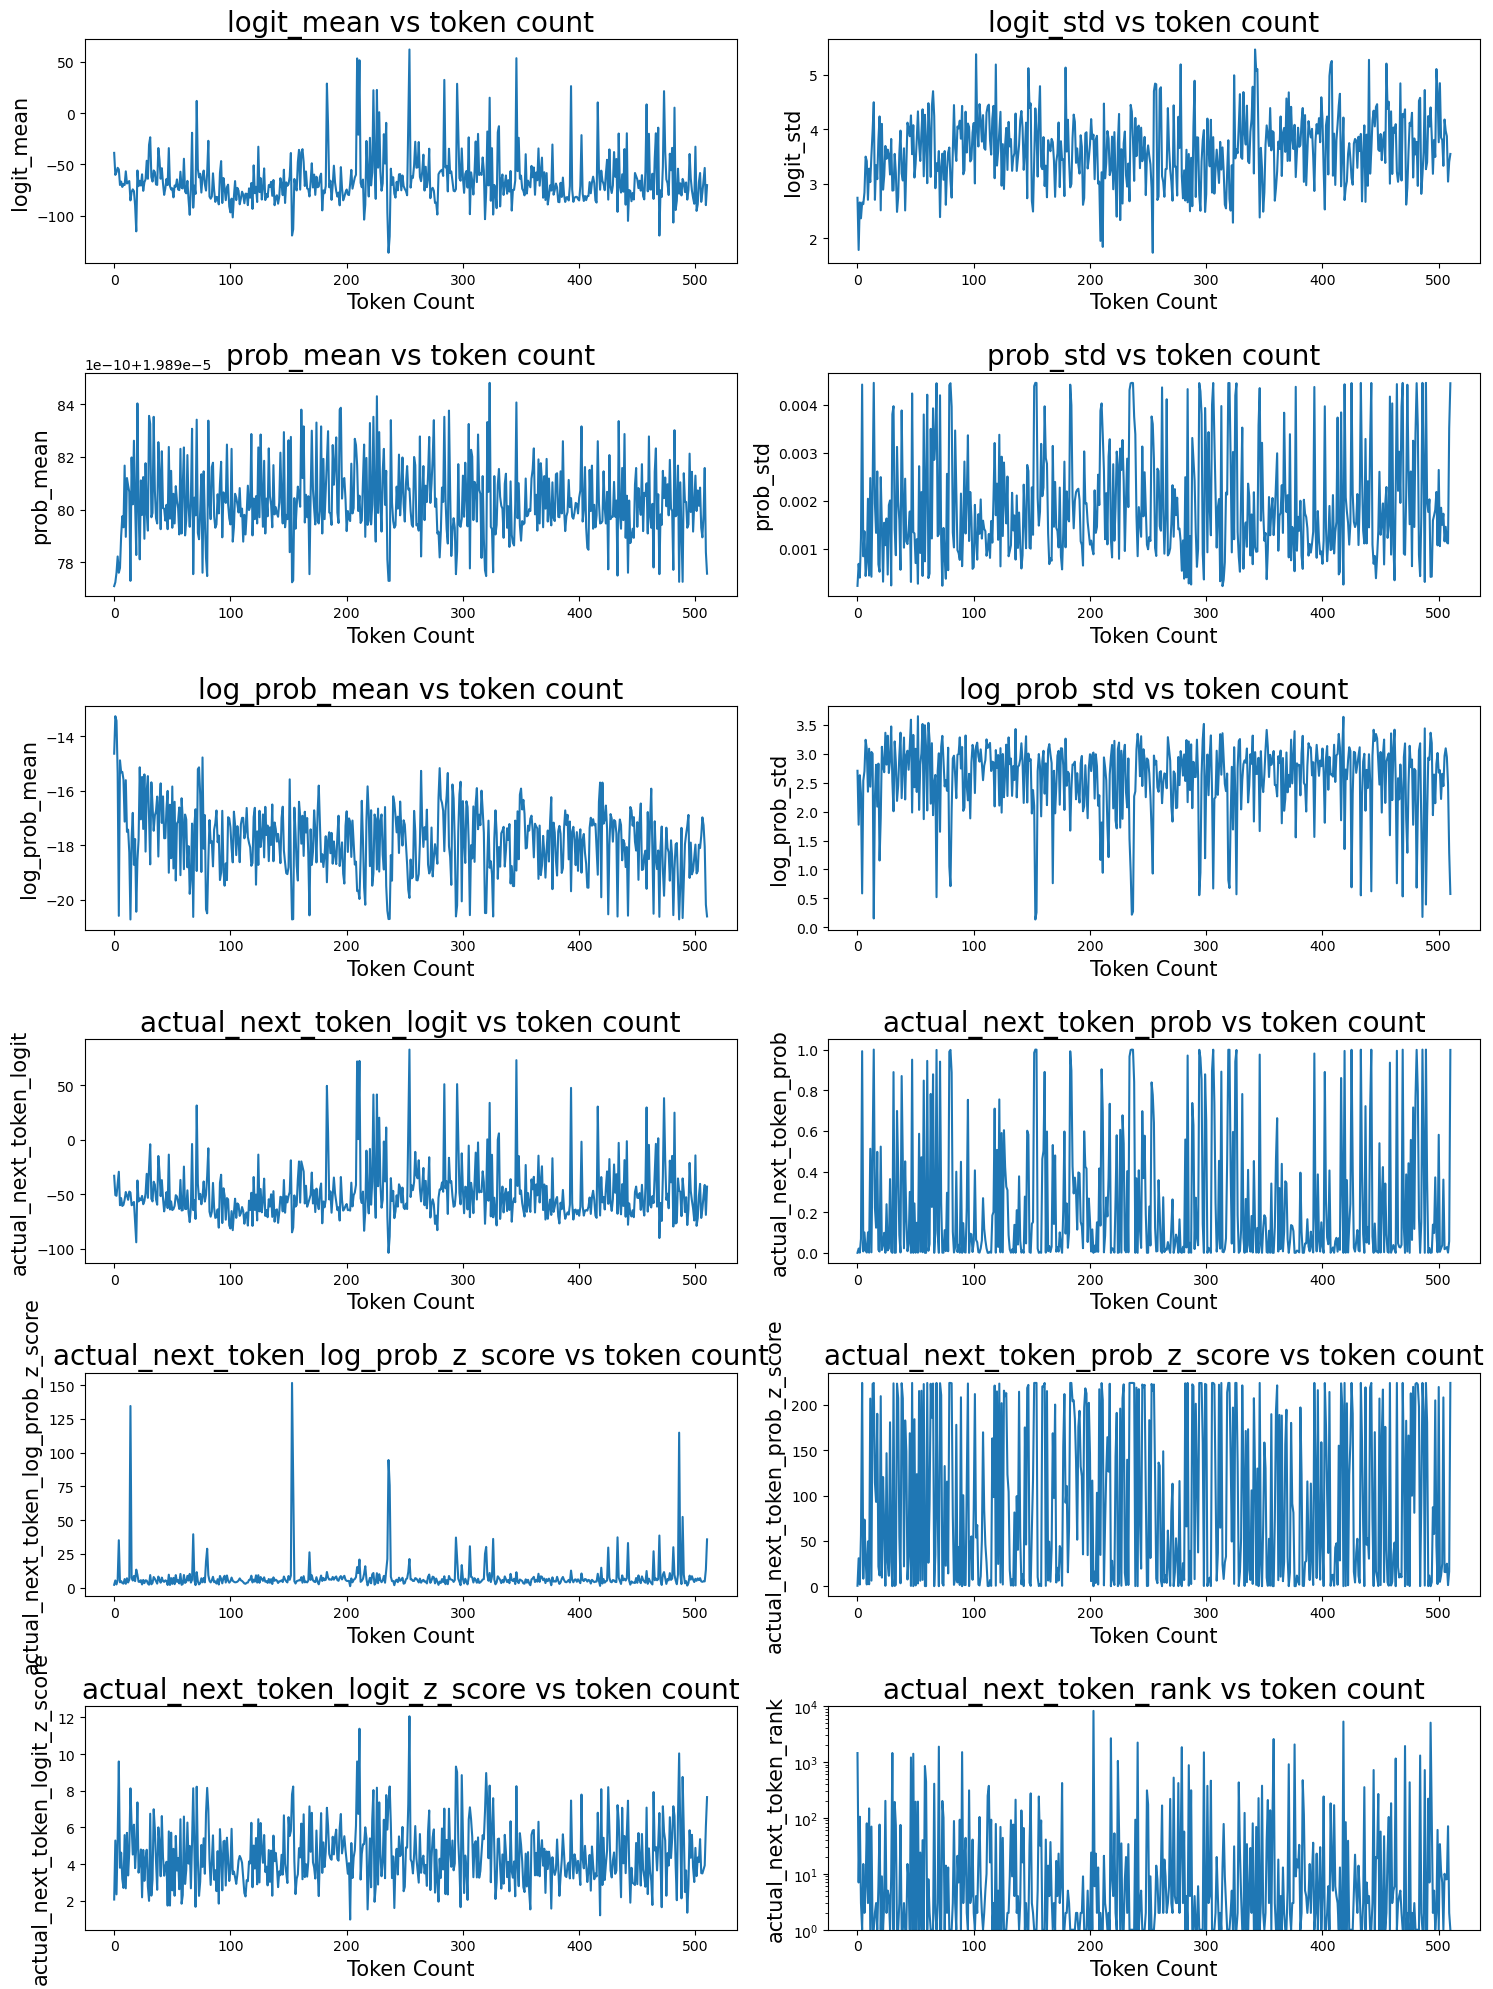

In [27]:
plot_stats(statsdf, stat_cols, labelwords=False)

Other than the perplexity, it is interesting to look at the distribution of ranks of the next words. 

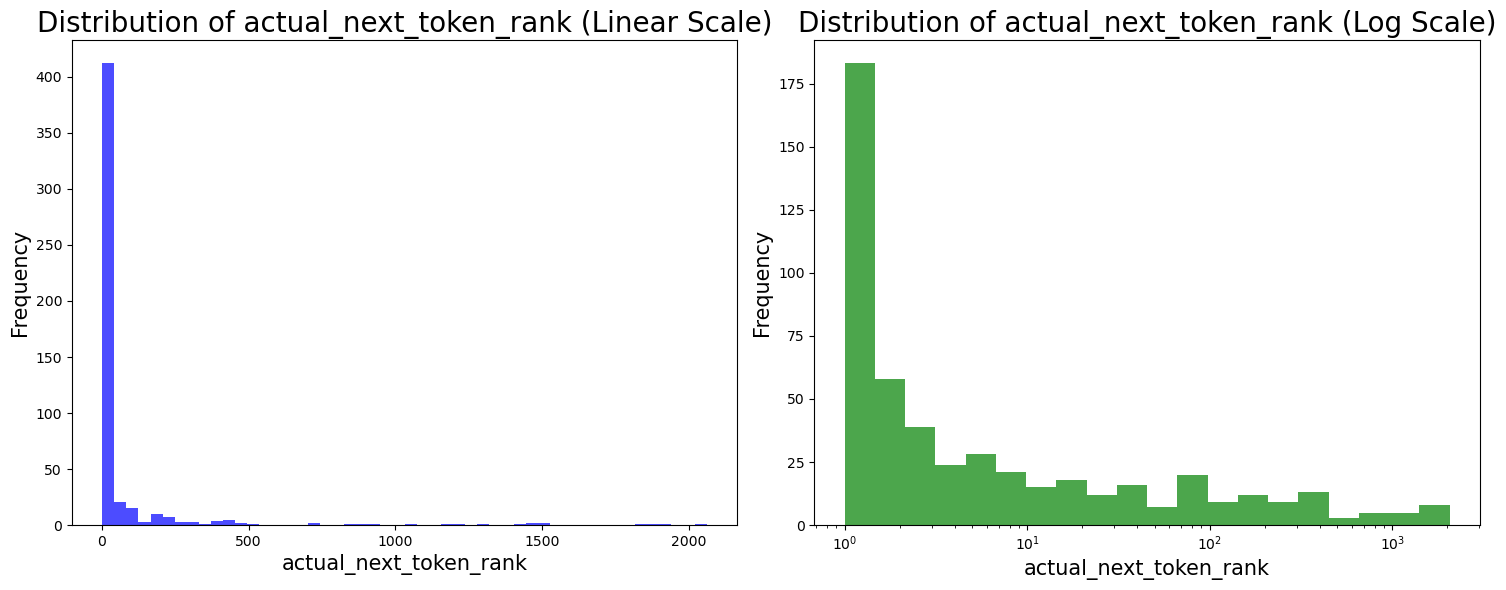

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Calculate the 99th percentile
percentile_99 = np.percentile(statsdf['actual_next_token_rank'], 99)

# Filter the data to include only values within the 99th percentile
filtered_data = statsdf[statsdf['actual_next_token_rank'] <= percentile_99]['actual_next_token_rank']

# Linear scale
axes[0].hist(filtered_data, bins=50, color='blue', alpha=0.7)
axes[0].set_title('Distribution of actual_next_token_rank (Linear Scale)', fontsize=20)
axes[0].set_xlabel('actual_next_token_rank', fontsize=15)
axes[0].set_ylabel('Frequency', fontsize=15)

# Plot histogram with log-spaced bins and set x-axis to log scale
axes[1].hist(filtered_data, bins=np.logspace(np.log10(filtered_data.min()), np.log10(filtered_data.max()), 21), color='green', alpha=0.7)
axes[1].set_xscale('log')  # Set log scale after plotting
axes[1].set_title('Distribution of actual_next_token_rank (Log Scale)', fontsize=20)
axes[1].set_xlabel('actual_next_token_rank', fontsize=15)
axes[1].set_ylabel('Frequency', fontsize=15)

plt.tight_layout()
plt.show()

Do the same thing, this time with AI generated version of pride and prejudice text.

1096


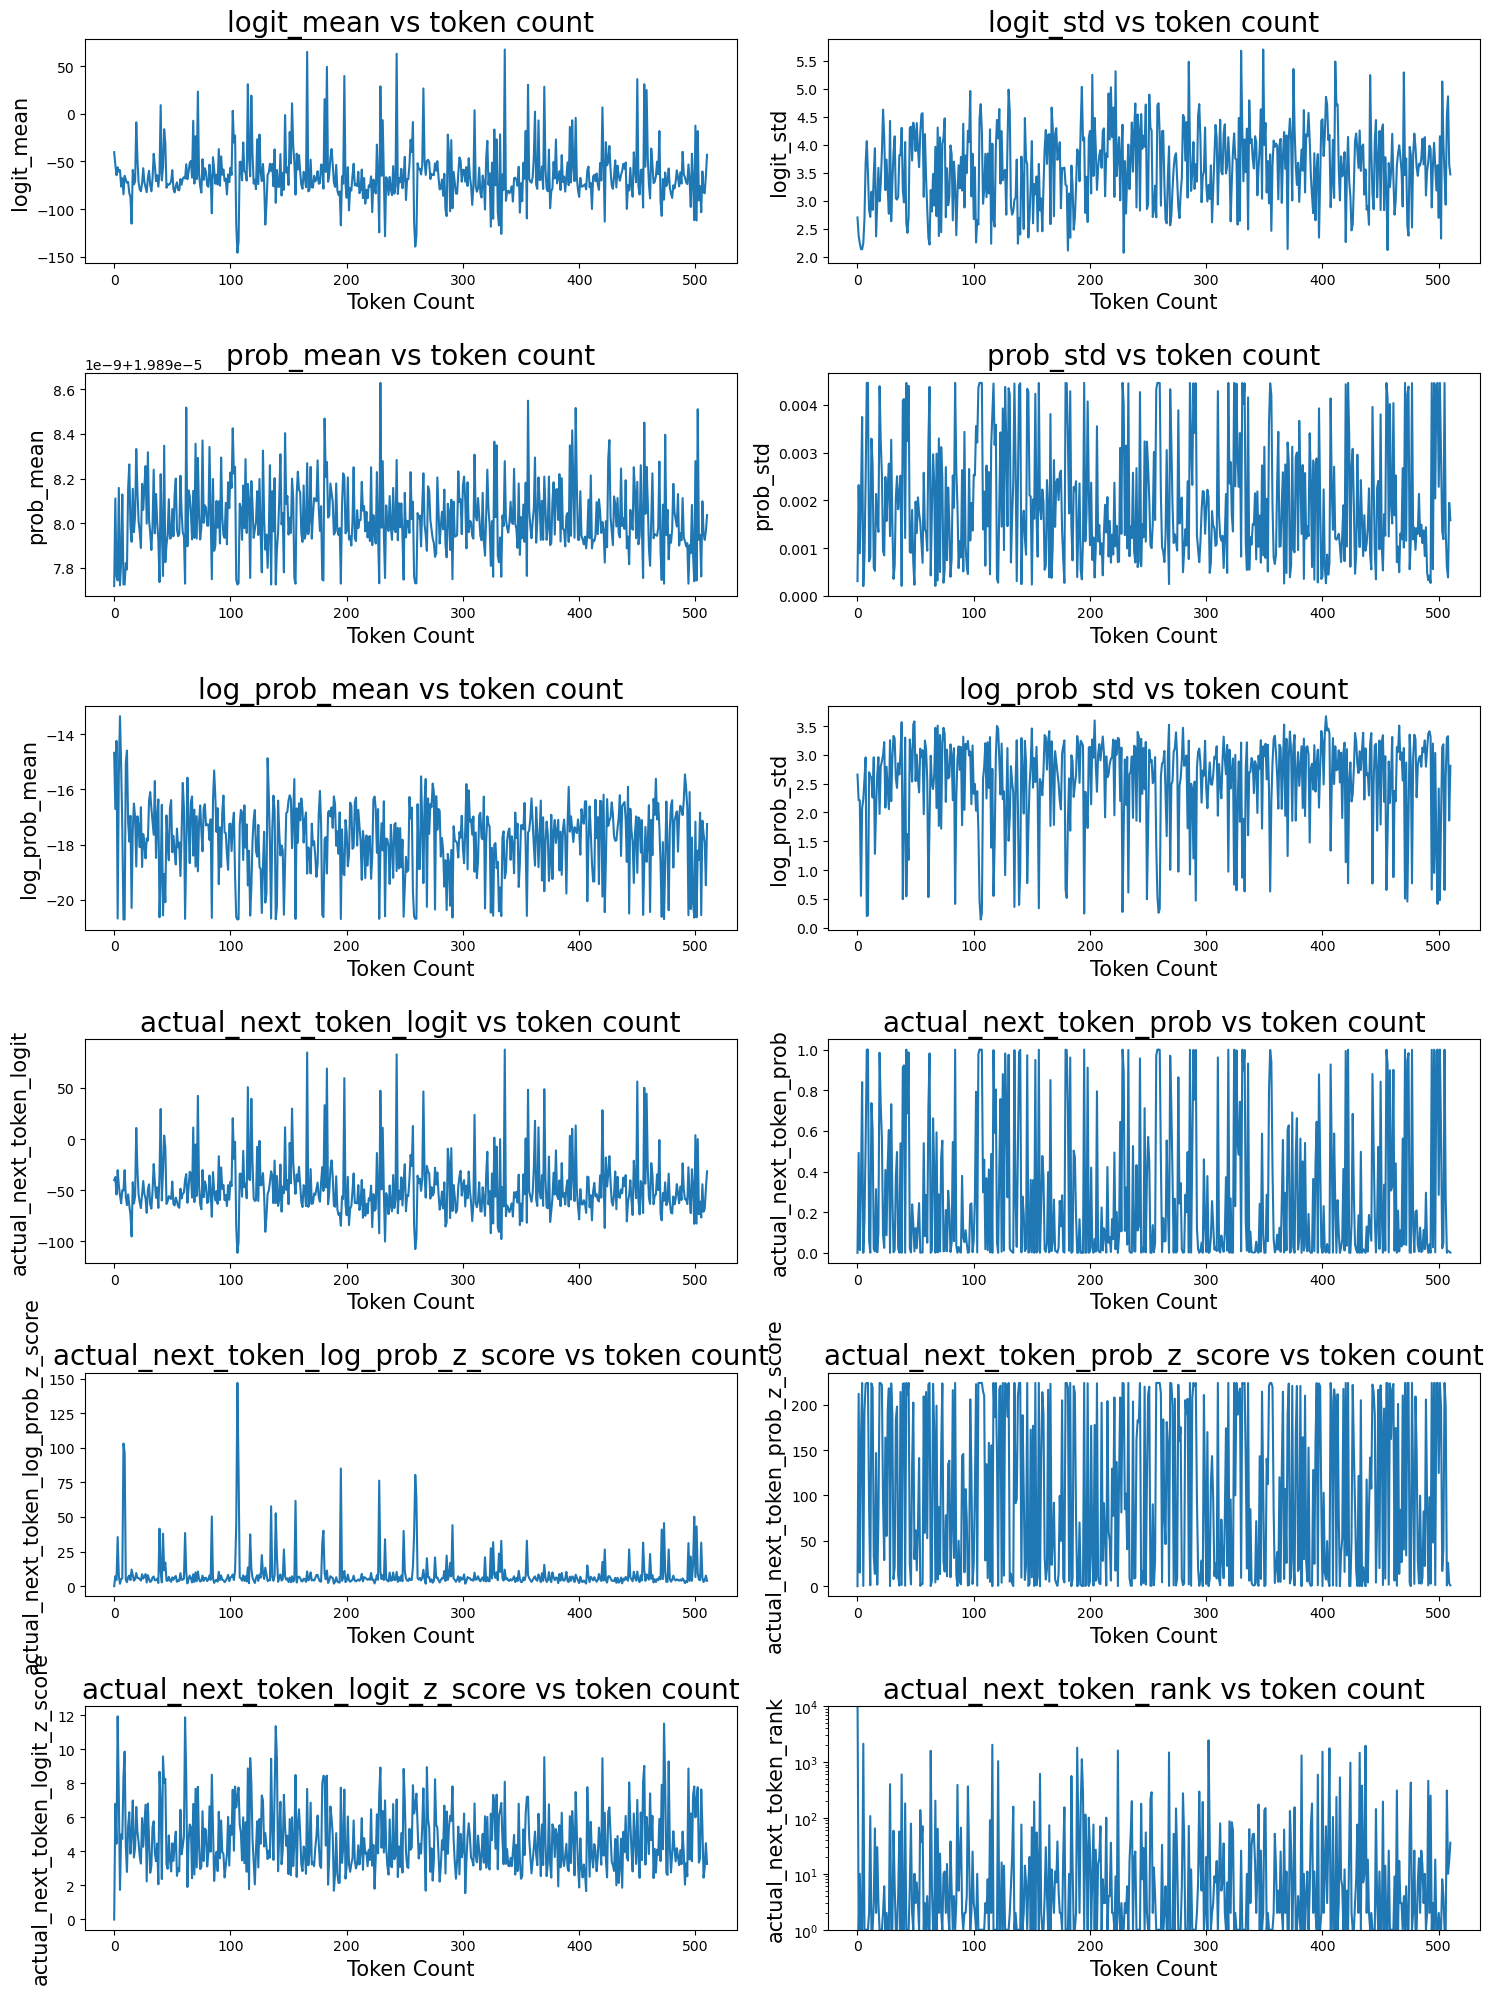

In [29]:

with open('utils/pride_ai.txt', 'r') as file:
    sample_text = file.read()
print(len(sample_text.split()))
results = get_sequential_predictions_stats(sample_text, max_tokens= 512)
statsdf = results_to_df(results)
statsdf['perplexity'] = calculate_cumulative_perplexity(statsdf['actual_next_token_prob'])
plot_stats(statsdf, stat_cols, labelwords=False)

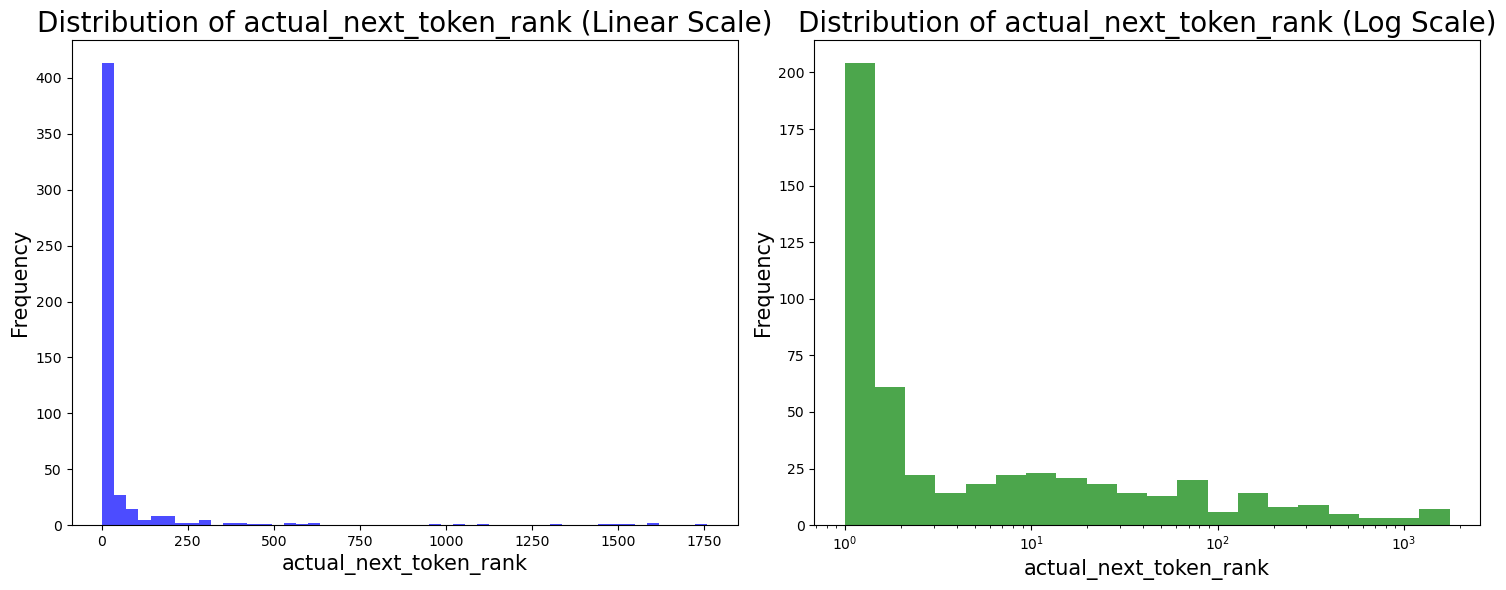

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Calculate the 99th percentile
percentile_99 = np.percentile(statsdf['actual_next_token_rank'], 99)

# Filter the data to include only values within the 99th percentile
filtered_data = statsdf[statsdf['actual_next_token_rank'] <= percentile_99]['actual_next_token_rank']

# Linear scale
axes[0].hist(filtered_data, bins=50, color='blue', alpha=0.7)
axes[0].set_title('Distribution of actual_next_token_rank (Linear Scale)', fontsize=20)
axes[0].set_xlabel('actual_next_token_rank', fontsize=15)
axes[0].set_ylabel('Frequency', fontsize=15)

# Plot histogram with log-spaced bins and set x-axis to log scale
axes[1].hist(filtered_data, bins=np.logspace(np.log10(filtered_data.min()), np.log10(filtered_data.max()), 21), color='green', alpha=0.7)
axes[1].set_xscale('log')  # Set log scale after plotting
axes[1].set_title('Distribution of actual_next_token_rank (Log Scale)', fontsize=20)
axes[1].set_xlabel('actual_next_token_rank', fontsize=15)
axes[1].set_ylabel('Frequency', fontsize=15)

plt.tight_layout()
plt.show()